Using LSTM to classify the movie reviews into positive and negative.


In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

Only keeping the necessary columns.

In [36]:
data = pd.read_excel('/content/cleaning_data_PSBB.xlsx')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

data.Sentiment=data.sentiment.astype(str)
data.text=data.text.astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


In [37]:
data.head()

text  sentiment
0  posisi kunci aman mudah pengaruh pinjam tipu o...          1
1  brigadir jenderal wisnu hermawan tahu polisi p...          2
2  tolong ada scam di akun instagram scam kedok p...          0
3                                 pinjam tipu online          0
4  kemudi dalam posisi kunci yang aman mudah peng...          1

Next, I am dropping the 'Neutral' sentiments as my goal was to only differentiate positive and negative tweets. After that, I am filtering the tweets so only valid texts and words remain.  Then, I define the number of max features as 2000 and use Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input.

In [38]:
print(data[ data['sentiment'] == 0].size)
print(data[ data['sentiment'] == 1].size)
print(data[ data['sentiment'] ==2].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt','')
data.head()

3288
1478
1316


text  sentiment
0  posisi kunci aman mudah pengaruh pinjam tipu o...          1
1  brigadir jenderal wisnu hermawan tahu polisi p...          2
2  tolong ada scam di akun instagram scam kedok p...          0
3                                 pinjam tipu online          0
4  kemudi dalam posisi kunci yang aman mudah peng...          1

In [87]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

Next, I compose the LSTM Network. Note that **embed_dim**, **lstm_out**, **batch_size**, **droupout_x** variables are hyperparameters, their values are somehow intuitive, can be and must be played with in order to achieve good results. Please also note that I am using softmax as activation function. The reason is that our Network is using categorical crossentropy, and softmax is just the right activation method for that.

In [88]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 128)           256000    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 40, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 196)               254800    
                                                                 
 dense_2 (Dense)             (None, 3)                 591       
                                                                 
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


Hereby I declare the train and test dataset.

In [89]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2432, 40) (2432, 3)
(609, 40) (609, 3)


Here we train the Network. We should run much more than 7 epoch, but I would have to wait forever for kaggle, so it is 7 for now.

In [91]:
batch_size = 64
history_validasi = model.fit(X_train, Y_train, validation_data=(X,Y),epochs = 100, batch_size=batch_size, verbose = 1)

Epoch 1/100
38/38 [==============================] - 6s 97ms/step - loss: 0.6913 - accuracy: 0.7327 - val_loss: 0.5847 - val_accuracy: 0.8103
Epoch 2/100
38/38 [==============================] - 4s 96ms/step - loss: 0.5105 - accuracy: 0.8092 - val_loss: 0.4431 - val_accuracy: 0.8494
Epoch 3/100
38/38 [==============================] - 4s 95ms/step - loss: 0.3719 - accuracy: 0.8713 - val_loss: 0.3593 - val_accuracy: 0.8839
Epoch 4/100
38/38 [==============================] - 4s 95ms/step - loss: 0.2869 - accuracy: 0.8997 - val_loss: 0.3114 - val_accuracy: 0.9027
Epoch 5/100
38/38 [==============================] - 4s 104ms/step - loss: 0.2244 - accuracy: 0.9293 - val_loss: 0.2758 - val_accuracy: 0.9135
Epoch 6/100
38/38 [==============================] - 4s 104ms/step - loss: 0.1819 - accuracy: 0.9391 - val_loss: 0.2679 - val_accuracy: 0.9217
Epoch 7/100
38/38 [==============================] - 4s 106ms/step - loss: 0.1358 - accuracy: 0.9605 - val_loss: 0.2782 - val_accuracy: 0.9267
Epo

Extracting a validation set, and measuring score and accuracy.

In [92]:
Y_pred = model.predict(X_test,batch_size = batch_size)

Y_pred = np.round(Y_pred).astype(int)


In [93]:
scores = model.evaluate(X, Y)
print("Akurasi data Testing = %.2f%%" % (scores[1]*100))

96/96 [==============================] - 1s 14ms/step - loss: 0.3887 - accuracy: 0.9438
Akurasi data Testing = 94.38%


In [94]:
print("confusion matrix")
confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

confusion matrix


array([[251,  39,  37],
       [ 25,  93,  28],
       [ 15,  20, 101]])

In [95]:
from sklearn.metrics import classification_report, plot_confusion_matrix
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       327
           1       0.61      0.64      0.62       146
           2       0.61      0.74      0.67       136

    accuracy                           0.73       609
   macro avg       0.69      0.72      0.70       609
weighted avg       0.75      0.73      0.74       609



In [96]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

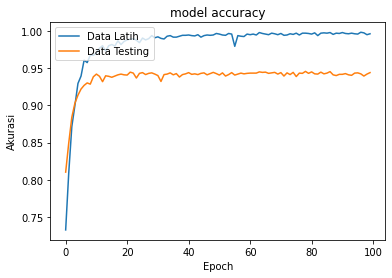

In [97]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from tensorflow.keras.optimizers import Adam 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.activations import relu
import pandas as pd
import sklearn
import keras

plt.plot(history_validasi.history['accuracy'])
plt.plot(history_validasi.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['Data Latih', 'Data Testing'], loc='upper left')
plt.show()

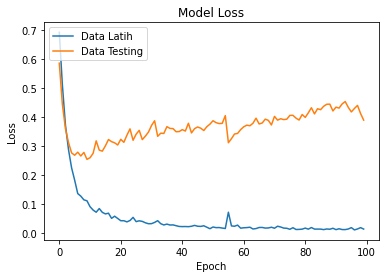

In [98]:
plt.plot(history_validasi.history['loss'])
plt.plot(history_validasi.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Data Latih', 'Data Testing'], loc='upper left')
plt.show()